# GAMALOS (GAlaxies MAking LOve Simulation)

## Theoric remarks

Report: write a short report containing:
- a short introduction to the N-body problem, the difference between
collisional and collisionless systems and the force estimate in
collisionless simulations based on tree algorithms. Short general
description of the fireworks package and its implementation.
- Description of the methods (integrators, force estimator) used.
- Description of the initial conditions and simulation setup.
- Results and discussion. They depends on the specific project you
chose, but I expect at least one plot showing the main conclusion of
your analysis.

<div class='alert alert-danger' role='alert'>
Inserisci info teoriche
</div>

## Computation

In [1]:
#first of all, we import all the packages for Particles, integrators, ic...

import numpy as np
import pandas as pd
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_euler, integrator_leapfrog, integrator_rungekutta
from fireworks.nbodylib.dynamics import acceleration_direct_vectorized #, acceleration_direct, acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
import time

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

We can import the data of one galaxy at first. The units are still Nbody units.

In [2]:
df = pd.read_csv("data_cvs/Nbody_disc.csv")
print(df)

                mass          x         y    z        vx        vy   vz
0       1.000000e+00   0.000000  0.000000  0.0  0.000000  0.000000  0.0
1       1.000000e-11  -3.419583 -1.901788  0.0  0.118878 -0.213752  0.0
2       1.000000e-11 -14.046839 -2.403541  0.0  0.040952 -0.239330  0.0
3       1.000000e-11  -4.618003  6.269821  0.0 -0.222721 -0.164044  0.0
4       1.000000e-11  -6.045516  0.257974  0.0 -0.011730 -0.274897  0.0
...              ...        ...       ...  ...       ...       ...  ...
99996   1.000000e-11  -6.351708 -6.128203  0.0  0.189681 -0.196599  0.0
99997   1.000000e-11  -5.904495 -6.226256  0.0  0.198940 -0.188659  0.0
99998   1.000000e-11   2.474930  6.513013  0.0 -0.259340  0.098548  0.0
99999   1.000000e-11  -2.877171 -4.125827  0.0  0.218440 -0.152330  0.0
100000  1.000000e-11   4.043463  0.039636  0.0 -0.002431  0.247963  0.0

[100001 rows x 7 columns]


### 1. Initial conditions
We generated a Particles instance for each galaxy

In [3]:
# create a class with the mass, pos, vel of each element of the Galaxy

masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]
Galaxy1 = Particles(positions.values, velocities.values, masses.values)

In [4]:
print(positions.values)

[[  0.           0.           0.        ]
 [ -3.41958304  -1.90178796   0.        ]
 [-14.04683878  -2.40354145   0.        ]
 ...
 [  2.4749302    6.51301345   0.        ]
 [ -2.87717096  -4.12582673   0.        ]
 [  4.04346311   0.03963641   0.        ]]


In [5]:
# do the same for the other galaxy
# this second galaxy is the same as the first one, but translated by a certain value

pos_translation = np.array((40., 20., 0.))
vel_translation = np.array((-0.2, 0., 0.))

# apply this translation to find the second galaxy

positions_gal_2 = positions.values + pos_translation
velocities_gal_2 = velocities.values + vel_translation
Galaxy2 = Particles(positions_gal_2, velocities_gal_2, masses.values)

In [6]:
# check if the particles class worked properly

print(Galaxy1.pos)
print(Galaxy2.pos)
print(Galaxy1.vel)
print(Galaxy2.vel)

[[  0.           0.           0.        ]
 [ -3.41958304  -1.90178796   0.        ]
 [-14.04683878  -2.40354145   0.        ]
 ...
 [  2.4749302    6.51301345   0.        ]
 [ -2.87717096  -4.12582673   0.        ]
 [  4.04346311   0.03963641   0.        ]]
[[40.         20.          0.        ]
 [36.58041696 18.09821204  0.        ]
 [25.95316122 17.59645855  0.        ]
 ...
 [42.4749302  26.51301345  0.        ]
 [37.12282904 15.87417327  0.        ]
 [44.04346311 20.03963641  0.        ]]
[[ 0.          0.          0.        ]
 [ 0.11887751 -0.21375228  0.        ]
 [ 0.04095161 -0.23933043  0.        ]
 ...
 [-0.25933956  0.09854844  0.        ]
 [ 0.2184396  -0.15233022  0.        ]
 [-0.00243068  0.24796345  0.        ]]
[[-0.2         0.          0.        ]
 [-0.08112249 -0.21375228  0.        ]
 [-0.15904839 -0.23933043  0.        ]
 ...
 [-0.45933956  0.09854844  0.        ]
 [ 0.0184396  -0.15233022  0.        ]
 [-0.20243068  0.24796345  0.        ]]


### 2. Rotation curve
The rotation curve of a galaxy shows the azimuthal velocity as function of the cylindrical radius . To estimate the azimuthal velocity for each particle we transform the Cartesian coordinates to cylindrical: 

$$
\begin{cases}
R = \sqrt(x^2+y^2) \\
\phi = \arctan(\frac{y}{x}) \\
z=z
\end{cases}
$$

We then computed the azymuthal velocity for all the particles using: 
$$
V_\phi = V_y \cdot \cos(\phi) - V_x\cdot \sin(\phi)
$$

We then plotted $V_\phi$ vs $R$ to obtain the rotation curve of the galaxy. 


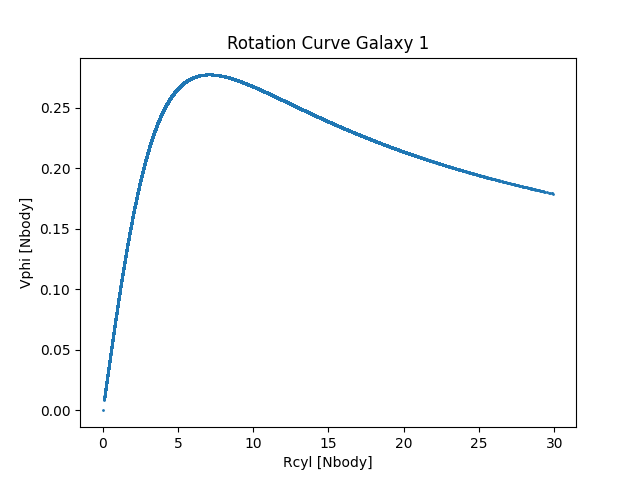

In [26]:
# convert to cylindrical coordinates

Rcyl = np.sqrt(Galaxy1.pos[:, 0] ** 2 + Galaxy1.pos[:, 1] ** 2)
phi = np.arctan2(Galaxy1.pos[:, 1], Galaxy1.pos[:, 0])
z = Galaxy1.pos[:, 2]

vel_phi = Galaxy1.vel[:, 1] * np.cos(phi) - Galaxy1.vel[:, 0] * np.sin(phi)

plt.figure()
plt.plot(Rcyl, vel_phi, 'o', markersize=1)
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Vphi [Nbody]")
plt.title("Rotation Curve Galaxy 1")
plt.show()


### 3. Surface profile density